# 1. Sentiment

## a. Analysis

In [1]:
import pandas as pd
from transformers import pipeline

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = pd.read_csv("../../Data Collection/Play Store/play_store_reviews_no_index.csv")
reviews = list(dataset["Reviews"])
reviews

["The app is awesome, I could learn a lot and choose what language as well as teachers who I want to study with, the interface is awesome, easy to understand and has a lot of fitures. I don't know if the others is having the troubles, but in my realme 7 device, the app has drain a lot of battery consumsion in the background, even if I don't open it at all. I hope and I know that Cakap Team would help solve problem and perfecting the app. Thanks",
 "This app works on me. But in my opinion, it still needs to be improved, especially when I change the screen to horizontal, the video cannot display the duration of the video being played. So if I want to loop or jump to my desired sequence, it's a little annoying. Because I can only press 10 seconds ahead before or after. Hopefully you can fix it, but this app is great because there is no buffering while watching videos 😀😊",
 "Just downloaded, update profile then reatarted, then stuck on boot the apps and stopped in C sign only. I've waited 

In [4]:
def analyze_sentiment(text_to_analyze):
    # Specify the model and revision explicitly
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    revision = "af0f99b"

    # Load the sentiment analysis pipeline with explicit model and revision
    sentiment_analyzer = pipeline(
        "sentiment-analysis", model=model_name, revision=revision)

    # Perform sentiment analysis
    sentiment_result = sentiment_analyzer(text_to_analyze)

    return sentiment_result

In [5]:
sentiments = analyze_sentiment(reviews)
sentiments

[{'label': 'NEGATIVE', 'score': 0.8592649102210999},
 {'label': 'POSITIVE', 'score': 0.7392206788063049},
 {'label': 'NEGATIVE', 'score': 0.9947157502174377},
 {'label': 'NEGATIVE', 'score': 0.8592649102210999},
 {'label': 'POSITIVE', 'score': 0.7392206788063049},
 {'label': 'NEGATIVE', 'score': 0.9947157502174377},
 {'label': 'POSITIVE', 'score': 0.9996906518936157},
 {'label': 'POSITIVE', 'score': 0.9998310804367065},
 {'label': 'POSITIVE', 'score': 0.9993857145309448},
 {'label': 'POSITIVE', 'score': 0.9997581839561462},
 {'label': 'POSITIVE', 'score': 0.999767005443573},
 {'label': 'POSITIVE', 'score': 0.9998449087142944},
 {'label': 'POSITIVE', 'score': 0.9996870756149292},
 {'label': 'POSITIVE', 'score': 0.9997822642326355},
 {'label': 'POSITIVE', 'score': 0.9998595714569092},
 {'label': 'POSITIVE', 'score': 0.9997462630271912},
 {'label': 'POSITIVE', 'score': 0.9958219528198242},
 {'label': 'POSITIVE', 'score': 0.9998791217803955},
 {'label': 'POSITIVE', 'score': 0.9996378421783

In [6]:
def get_df(sentences, sentiments):
    sents = {
        'review': sentences,
        'label': [senti['label'] for senti in sentiments],
        'score': [senti['score'] for senti in sentiments]
    }

    df = pd.DataFrame(sents)
    return df

In [7]:
senti_df = get_df(reviews, sentiments)
senti_df.head()

,review,label,score
0,"The app is awesome, I could learn a lot and ch...",NEGATIVE,0.859265
1,"This app works on me. But in my opinion, it st...",POSITIVE,0.739221
2,"Just downloaded, update profile then reatarted...",NEGATIVE,0.994716
3,"The app is awesome, I could learn a lot and ch...",NEGATIVE,0.859265
4,"This app works on me. But in my opinion, it st...",POSITIVE,0.739221


In [8]:
senti_df.to_csv("../../Data Analysis/Play Store/play_store_reviews_sentiment.csv", index=False)

## b. Visualization

In [9]:
import altair as alt

### 1) sentiments distribution

In [10]:
def pie_chart(poss, negs):
    total = poss + negs
    poss_perc = str(poss/total*100)+"%"
    negs_perc = str(negs/total*100)+"%"

    source = pd.DataFrame({
        "Label": ["Positive", "Negative"],
        "Count": [poss, negs],
        "Percentage": [poss_perc, negs_perc]
    })

    pie = alt.Chart(source).mark_arc().encode(
        theta="Count",
        color=alt.Color(
            "Label",
            scale=alt.Scale(
                domain=["Positive", "Negative"],
                range=["#19c2fa", "#fc3f3f"]
            )),
        tooltip=["Label", "Count", "Percentage"]
    )

    return pie

In [11]:
label_count = senti_df['label'].value_counts()
poss = label_count.get('POSITIVE')
negs = label_count.get('NEGATIVE')

pie = pie_chart(poss, negs)
pie.interactive()

alt.Chart(...)

### 2) rating prediction

In [12]:
pos_df = pd.DataFrame({
    "review": senti_df["review"],
    "positivity": senti_df.apply(lambda row: 1 - row['score'] if row['label'] == 'NEGATIVE' else row['score'], axis=1)
})

pos_df.head()

,review,positivity
0,"The app is awesome, I could learn a lot and ch...",0.140735
1,"This app works on me. But in my opinion, it st...",0.739221
2,"Just downloaded, update profile then reatarted...",0.005284
3,"The app is awesome, I could learn a lot and ch...",0.140735
4,"This app works on me. But in my opinion, it st...",0.739221


In [13]:
positivity = pos_df["positivity"]

normalized_scores = [(score * 4) + 1 for score in (positivity)]
# average_score = sum(normalized_scores) / len(normalized_scores)

source = pd.DataFrame({
    "score": normalized_scores
})
alt.Chart(source).mark_bar().encode(
    alt.X("score:Q", title="Ratings", bin=True),
    y='count()',
)

alt.Chart(...)

# 2. Topic Modelling

In [14]:
import pyLDAvis
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim_models as gensimvis
from gensim.parsing.preprocessing import preprocess_string

## a. Preprocessing

In [41]:
documents = reviews

In [42]:
# Preprocess text
processed_docs = [preprocess_string(doc) for doc in documents]

# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## b. Training and Visualization

In [61]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=50)

In [62]:
# Visualize topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## c. Coherence Score

In [63]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.31452520286852986


# 3. Word Cloud

In [64]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## a. Preprocessing

In [65]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))

    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()
              and token not in stop_words]
    return tokens

In [66]:
text = " ".join(reviews)
tokens = preprocess_text(text)

## b. Visualization

In [67]:
def generate_wordcloud(words):
    # Generate WordCloud for adjectives
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(words)

    # Display the WordCloud using matplotlib
    _, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

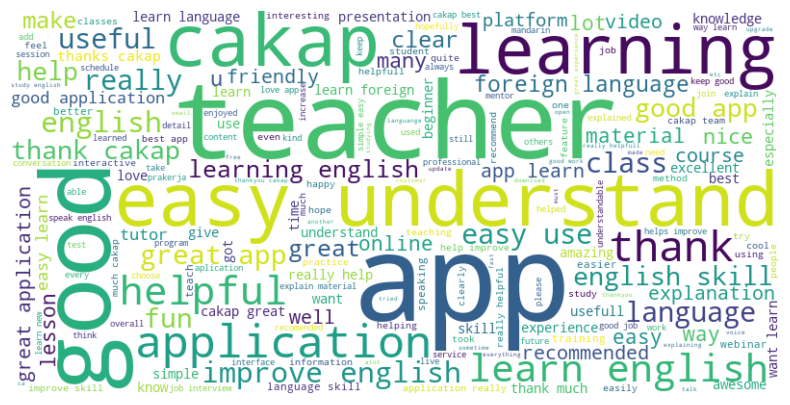

In [68]:
processed_text = " ".join(tokens)
generate_wordcloud(processed_text)